
# PRACTICA NLP. NOTEBOOK 1


## 1.- Descarga y exploración del corpus

El alumno descargará el/los corpus que desee (detalle sobre los datos a utilizar en
el siguiente punto) y realizará un análisis exploratorio de los datos.
Este ejercicio deberá contener:
- Cardinalidad del vocabulario
- Distribución de reviews por número de estrellas
- Nº de reviews positivas y negativas
- N-grams más frecuentes
- Nubes de palabras
- Visualización en 2 dimensiones de algunos word embeddings calculados con
Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)
- Conclusiones de la exploración
- Cualquier otra métrica / exploración / cálculo que el alumno considere

Link a descarga de los corpus con los que trabajar:
https://nijianmo.github.io/amazon/index.html

In [2]:
#LIBRERIAS QUE PUEDO NECESITAR:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline 

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re
import bz2
import gzip
import json
import string
from nltk import word_tokenize

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from collections import Counter
from itertools import chain
from wordcloud import WordCloud
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
#cargo el dataset en pandas. 
#como voy a probar más de 1 cargo de momento 3, de diferentes tamaños 
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)
               
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df_music_inst = getDF('Musical_Instruments_5.json.gz')
df_garden = getDF('Patio_Lawn_and_Garden_5.json.gz')
df_science = getDF('Industrial_and_Scientific_5.json.gz')

In [4]:
#hago una revisión inicial de los 3 por encima
df_music_inst.head(2).T

#asin: id of the product
#summary: summary
#overall: number of stars
#reviewText: review
#reviewerName...


,0,1
overall,5,5
verified,True,True
reviewTime,"10 30, 2016","06 30, 2016"
reviewerID,A3FO5AKVTFRCRJ,A3UCGC1DHFMBCE
asin,0739079891,0739079891
reviewerName,francisco,Eb Jack Murray
reviewText,It's good for beginners,I recommend this starter Ukulele kit. I has everything you\nneed to learn the Ukulele.
summary,Five Stars,Five Stars
unixReviewTime,1477785600,1467244800
vote,NaN,NaN


In [5]:
df_garden.head(2).T

,0,1
overall,5,5
vote,2,NaN
verified,True,True
reviewTime,"12 11, 2011","07 30, 2011"
reviewerID,AUVPE2KEXBJVT,A2F6GES1MBOFXS
asin,9539723809,9539723809
reviewerName,T. E. Kainz,BluesJamJim
reviewText,"I don't spend a lot on my flags because they really get beat up. So I but the lesser quality figuring that they'll have to be replaced a couple of times a year anyways. The fact that this very inexpensive flag is still flying 8 months later pleases me well. It's up about 20 feet, 7/24, and sees winds averaging 5 to 10 mph on a 'normal' day with the occasional storm friont gusts reaching as high as 60+ mph. So far (8 months later) it's just now starting to show a little fraying on the ends. I'll be buying another shortly to have ready when this one finally gives in.","Super fast processing and shipping, if you are looking for flags look no more good quality product and a great company to do business with."
summary,Good quality for the price,3'x5' Colorado State flag
unixReviewTime,1323561600,1311984000


In [6]:
df_science.head(2).T

,0,1
overall,5,5
verified,True,True
reviewTime,"11 27, 2017","11 4, 2017"
reviewerID,A1JB7HFWHRYHT7,A2FCLJG5GV8SD6
asin,B0000223SI,B0000223SI
style,{'Size:': ' 1-(Pack)'},{'Size:': ' 1-(Pack)'}
reviewerName,Alex W.,Randall Harris
reviewText,"This worked really well for what I used it for. So for my purposes it is getting full marks. This is an all around great, durable, and afforable sandpaper.\n\nPros:\n-Grit cuts really fast and evenly. No random deep scratches like I have seen in some cheaper paper\n-Didn't even have a hint of clogging up.\n-The adhesive is just what I needed. No permanent, but wasn't going anywhere.\n\nCons:\n-None",Fast cutting and good adheasive.
summary,Couldn't have been happier with it's performance,Good paper.
unixReviewTime,1511740800,1509753600


In [7]:
# Probablemente sea buena idea seleccionar una muestra similar de los 3 para trabajar en condiciones similares con los 3.
# espero a ver cómo se reparten las valoraciones para intentar que estén lo más balanceadas posible. 
print('Tamaño del dataset original de instrumentos musicales: ', df_music_inst.shape)
print('Tamaño del dataset original de garden: ', df_garden.shape)
print('Tamaño del dataset original de industrial y ciencia: ', df_science.shape)

Tamaño del dataset original de instrumentos musicales:  (231392, 12)
Tamaño del dataset original de garden:  (798415, 12)
Tamaño del dataset original de industrial y ciencia:  (77071, 12)


#### Avanzo con el primer dataset y luego aplico lo que hago en el primero a los otros dos. Es una forma de ver generalización 


In [8]:
df_music_inst.info()
#reduzco variables, me interesan en principio overall como label y reviewText y summary para el corpus.Estas dos últimas tienen algunos nulos.
#limpio las entradas en las que review y summary puedan estar en blanco y concateno para que si no es un campo, el otro esté relleno y aporte información. 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 231392 entries, 0 to 231391
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         231392 non-null  float64
 1   verified        231392 non-null  bool   
 2   reviewTime      231392 non-null  object 
 3   reviewerID      231392 non-null  object 
 4   asin            231392 non-null  object 
 5   reviewerName    231367 non-null  object 
 6   reviewText      231344 non-null  object 
 7   summary         231341 non-null  object 
 8   unixReviewTime  231392 non-null  int64  
 9   vote            34777 non-null   object 
 10  style           121310 non-null  object 
 11  image           3889 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 21.4+ MB


In [9]:
#localizo los NaN en reviewText a ver si en general tienen summary
df_inst_series=pd.isnull(df_music_inst['reviewText']) 
df_music_inst[df_inst_series].head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
16840,5.0,True,"01 25, 2018",A3N0SYVG1A2T5Y,B0002E1NNC,Robert h.,NaN,Five Stars,1516838400,NaN,"{'Size:': ' HD Light (.013-.053)', 'Style:': ' 80/20 NANOWEB Coating'}",NaN
16999,5.0,True,"11 18, 2017",A2ACJCJOSZOW8Z,B0002E1NNC,Private,NaN,Excellent Strings!,1510963200,NaN,"{'Size:': ' Light (.012-.053)', 'Style:': ' 80/20 NANOWEB Coating'}",NaN
17465,5.0,True,"01 25, 2018",A3N0SYVG1A2T5Y,B0002E1NWI,Robert h.,NaN,Five Stars,1516838400,NaN,NaN,NaN
17627,5.0,True,"11 18, 2017",A2ACJCJOSZOW8Z,B0002E1NWI,Private,NaN,Excellent Strings!,1510963200,NaN,NaN,NaN
25914,5.0,True,"02 29, 2016",A2TB3K1Z2YG1O4,B0002E3CK4,Kelly,NaN,Five Stars,1456704000,NaN,"{'Size:': ' Regular Light, 10-46', 'Style:': ' 3-Pack'}",NaN


In [10]:
#y los de summary a ver si tienen text
df_inst_series_sum=pd.isnull(df_music_inst['summary'])   
df_music_inst[df_inst_series_sum].head()

#sólo hay uno que no tenga ni review ni summary. 5 stars, pero podrían ser más en otros datasets y podría darse el caso de querer aprovechar toda la información. 

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
4758,5.0,True,"03 13, 2014",A3010VBY64UGRH,B0002CZW0Y,Lamont,I just bought this and I can't say anything negative about it. It does it's job. Nice basic product no need to look further,NaN,1394668800,NaN,{'Style:': ' Pop Filter with Stablizing Arm'},NaN
5338,5.0,True,"09 8, 2014",A157T7ALB7BE89,B0002CZTI4,Seer1,Great Product. Great Packaging. Great Price. Great People to do Business with.\n\nMahalo Nui Loa (Hawai'ian: Thank You Very Much) for fulfilling your obligation in a glorious way.\n\nCheers ><>,NaN,1410134400,NaN,{'Style:': ' 88 Note'},NaN
8011,5.0,True,"03 1, 2015",A3KR9XO6MX9GZJ,B0002D09Q0,lauren,Best sax reeds,NaN,1425168000,NaN,{'Size:': ' Strength 3.5'},NaN
10717,5.0,False,"05 11, 2017",A3DT5MYASB9M90,B0002D0CQC,joshua,"This is definitely the best of the string cleaners i have tried. This products does more than what i claims it conditions your strings extending the life and keeping them in tune, and also oils the strings making your guitar easier to play while not leaving to much oil behind, it also cleans and protects your strings.",NaN,1494460800,NaN,{'Size:': ' One Bottle'},NaN
13330,5.0,True,"03 1, 2015",A3KR9XO6MX9GZJ,B0002D09Y2,lauren,Best reeds for clarinet,NaN,1425168000,NaN,{'Size:': ' 3.5'},NaN


In [11]:
#limpio la entrada en la que no hay ni reviewText ni summary. las otras valoraciones de texto puedo sacarlas de uno u otro 

df_music_inst= df_music_inst.dropna(subset = ['reviewText','summary'],how='all')

In [12]:
#se me ocurre que podría revisar si influyen las personas en el tipo de review (si los que escriben muchas reviews tienden a poner todas positivas o todas negativas a alguna marca en particular..)...y si influye la hora de review. pero para prácticas futuras. 

df_music_inst= df_music_inst.drop(['verified','reviewTime','reviewerID','reviewerName','asin','unixReviewTime','vote','style','image'],axis=1)

In [13]:
df_music_inst.shape

(231391, 3)

In [14]:
df_music_inst.head(2)

,overall,reviewText,summary
0,5.0,It's good for beginners,Five Stars
1,5.0,I recommend this starter Ukulele kit. I has everything you\nneed to learn the Ukulele.,Five Stars


In [15]:
#Paso a concatenar reviewText y summary pero primero quito el nan y lo convierto en espacio en blanco. 
df_music_inst['reviewText'].fillna('',inplace=True)
df_music_inst['summary'].fillna('',inplace=True)

df_music_inst["review"] = df_music_inst['reviewText'].str.cat(df_music_inst[['summary']], sep=' ')

In [16]:
#Compruebo que no me quedan nulos 
df_music_inst.isnull().sum()

overall       0
reviewText    0
summary       0
review        0
dtype: int64

In [17]:
#elimino summary y reviewText y me quedo con review
df_music_inst=df_music_inst.drop(['summary','reviewText'],axis=1)

In [18]:
#pruebo que veo que las reviews están 
df_music_inst.review[2]

"G'daughter received this for Christmas present last year and plays if often. Learning new songs to play regularly"

#### CARDINALIDAD DEL VOCABULARIO: 
Para poder dar respuesta a la cardinalidad como primera pregunta, entiendo que es necesaria únicamente una primera aproximación al vocabulario que tengo en este dataset (hay que tener en cuenta que voy a hacer subset en los dataset...)
Quito mayúsculas y signos de puntuación y cuento mi vocabulario en bruto, palabras tal cual. 
En el siguiente notebook lematizo, quito stopwords..convierto números a string...limpieza general y preprocesado.

In [19]:
texts = df_music_inst['review'].str.lower()
texts= texts.str.split()
print(type(texts))  
print(len(texts))
#con esto obtengo una list de lists de palabras

<class 'pandas.core.series.Series'>
231391


In [20]:
#me quedo con lo alfanumérico y quito signos de puntuación. 
from nltk.tokenize import RegexpTokenizer
text=df_music_inst['review'].str.lower()
tokenizer = RegexpTokenizer(r'\w+')
words=tokenizer.tokenize('\n'.join(text))

In [21]:
#quitar repetidos en las dos listas
vocab= sorted(set(words))

In [22]:
print(type(words)) 
print(type(vocab))
 #todas son lo mismo (listas)

<class 'list'>
<class 'list'>


In [23]:
# Quitando sólo mayúsculas (pasando a minúsculas) me salen las siguientes palabras en total y palabras sin repetir. 

print('Número de palabras sin quitar repetidas: ', len(words))
print('Número de palabras quitando repetidas: ', len(vocab))

Número de palabras sin quitar repetidas:  14607209
Número de palabras quitando repetidas:  75795


In [24]:
print(words[:25])

['it', 's', 'good', 'for', 'beginners', 'five', 'stars', 'i', 'recommend', 'this', 'starter', 'ukulele', 'kit', 'i', 'has', 'everything', 'you', 'need', 'to', 'learn', 'the', 'ukulele', 'five', 'stars', 'g']


In [26]:
print(vocab[22500:22550])        
#print(vocab[60150:60500])

['diamond', 'diamondback', 'diamonds', 'diamter', 'diana', 'dianna', 'diap', 'diapason', 'diaper', 'diaphragm', 'diaphragmatic', 'diaphragms', 'diaphram', 'diappoint', 'diappointed', 'diappointing', 'diarias', 'diarmond', 'diary', 'diasy', 'diatone', 'diatonic', 'diatonics', 'diatribe', 'diavlo', 'diaz', 'dicast', 'dice', 'dicent', 'dicer', 'dicers', 'dices', 'dicey', 'dicing', 'dick', 'dickens', 'dicker', 'dickey', 'dickies', 'dicking', 'dicoloration', 'dicribed', 'dics', 'dictate', 'dictated', 'dictates', 'dictating', 'dictation', 'dictations', 'diction']


In [27]:
#finalmente, con una limpieza preliminar mi dataset tiene el siguiente vocabulario:
print('El vocabulario del dataset de instrumentos musicales, entendido como conjunto de palabras distintas de un texto es:  ')
print(len(vocab))


El vocabulario del dataset de instrumentos musicales, entendido como conjunto de palabras distintas de un texto es:  
75795


In [28]:
#guardo el archivo de textos por si lo vuelvo a necesitar en otro notebook
with open("file_texts.txt", 'w') as output:
    for row in texts:
        output.write(str(row) + '\n')

#### Distribución de reviews por número de estrellas

In [29]:
print('El reparto de las reviews por valoración es: ')
print(df_music_inst.overall.value_counts())

# Hay desbalanceo de clases. Bajo mi punto de vista deberíamos verlo como algo normal, pero de cara a entrenar un modelo quizá sea importante equilibrar en la medida de lo posible las valoraciones.
# Ni siquiera agrupando por valoraciones se equilibra ya que hay muchas más con 5 estrellas que del resto. 


El reparto de las reviews por valoración es: 
5.0    161836
4.0    38783 
3.0    16030 
1.0    7465  
2.0    7277  
Name: overall, dtype: int64


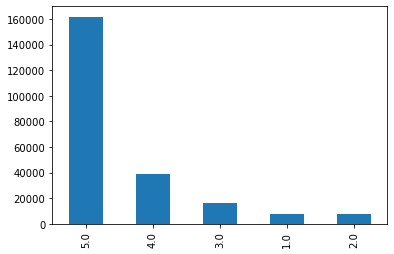

In [30]:
ax=df_music_inst.overall.value_counts().plot(kind='bar')
fig = ax.get_figure()
fig.savefig("score.png");

In [31]:
#Basándome en un criterio de valoración positiva entendida como 4 ó 5, a partir del 3 considero que no es positiva, y como voy a realizar una clasificación binaria y para igual el número de reviews, sumo las 3 a las negativas. 
#idea a desarrollar si me sobra tiempo: utilizar el 3 para contrastarlo con un listado de palabras de sentimiento positivo y negativo sacado de un estudio de Bo Pang and Lillian Lee (Seeing stars: Exploiting class relationships for sentiment categorization with respect to rating scales, Proceedings of the ACL, 2005.) y ver con cuál de las dos listas encuentro más similitud.   
df_music_inst.overall[df_music_inst.overall<=3]=0
df_music_inst.overall[df_music_inst.overall>=4]=1

In [32]:
df_music_inst.head(3)

,overall,review
0,1.0,It's good for beginners Five Stars
1,1.0,I recommend this starter Ukulele kit. I has everything you\nneed to learn the Ukulele. Five Stars
2,1.0,G'daughter received this for Christmas present last year and plays if often. Learning new songs to play regularly


In [33]:
df_music_inst.overall.value_counts()

1.0    200619
0.0    30772 
Name: overall, dtype: int64

In [34]:
#decido quedarme con 30000 reviews positivas y otras tantas negativas. 
df_music_pos=df_music_inst[df_music_inst.overall==1][:30000]
df_music_neg=df_music_inst[df_music_inst.overall==0][:30000]

In [35]:
df_music_inst=df_music_pos.append(df_music_neg)

In [36]:
df_music_inst.shape

(60000, 2)

In [37]:
df_music_inst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 227281
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   overall  60000 non-null  float64
 1   review   60000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.4+ MB


In [38]:
#guardo el dataframe con estos ajustes para usarlo en los próximos notebooks.
df_music_inst.to_csv('df_music_inst.csv', sep=';', decimal='.', index=False)

#### N-grams más frecuentes

Miro bigramas y trigramas. Al igual que con las palabras, sería interesante verlos después de quitar stopwords y en este caso también se cuela algún signo de puntuación. Reviso si me da tiempo. 

In [39]:
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

df_music_inst['bigrams'] = df_music_inst['review'].map(lambda x: find_ngrams(x.split(" "), 2))
df_music_inst['trigrams'] = df_music_inst['review'].map(lambda x: find_ngrams(x.split(" "), 3))

In [40]:
df_music_inst.head(2)

,overall,review,bigrams,trigrams
0,1.0,It's good for beginners Five Stars,"[(It's, good), (good, for), (for, beginners), (beginners, Five), (Five, Stars)]","[(It's, good, for), (good, for, beginners), (for, beginners, Five), (beginners, Five, Stars)]"
1,1.0,I recommend this starter Ukulele kit. I has everything you\nneed to learn the Ukulele. Five Stars,"[(I, recommend), (recommend, this), (this, starter), (starter, Ukulele), (Ukulele, kit.), (kit., ), (, I), (I, has), (has, everything), (everything, you\nneed), (you\nneed, to), (to, learn), (learn, the), (the, Ukulele.), (Ukulele., Five), (Five, Stars)]","[(I, recommend, this), (recommend, this, starter), (this, starter, Ukulele), (starter, Ukulele, kit.), (Ukulele, kit., ), (kit., , I), (, I, has), (I, has, everything), (has, everything, you\nneed), (everything, you\nneed, to), (you\nneed, to, learn), (to, learn, the), (learn, the, Ukulele.), (the, Ukulele., Five), (Ukulele., Five, Stars)]"


In [41]:
# Bigramas más comunes. Bigram Frequency Counts
bigrams = df_music_inst['bigrams'].tolist()
bigrams = list(chain(*bigrams))
bigrams = [(x.lower(), y.lower()) for x,y in bigrams]

bigram_counts = Counter(bigrams)
most_common_bigram= bigram_counts.most_common(10)
most_common_bigram

[(('of', 'the'), 13278),
 (('', 'i'), 9859),
 (('on', 'the'), 9520),
 (('i', 'have'), 8693),
 (('for', 'the'), 8361),
 (('in', 'the'), 8190),
 (('if', 'you'), 7651),
 (('it', 'is'), 7237),
 (('for', 'a'), 7168),
 (('is', 'a'), 7116)]

In [42]:
type(most_common_bigram)

list

In [43]:
big_words= [str(w[0]) for w in most_common_bigram]
big_freqs= [w[1] for w in most_common_bigram]

big_freqs, big_words = zip(*sorted(zip(big_freqs, big_words)))

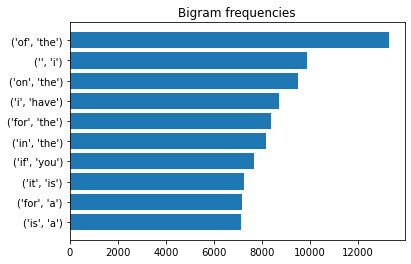

In [44]:
plt.barh(big_words, big_freqs)
plt.title('Bigram frequencies')
plt.show()

In [45]:
# Trigramas más comunes. trigram Frequency Counts
trigrams = df_music_inst['trigrams'].tolist()
trigrams = list(chain(*trigrams))
trigrams = [(x.lower(), y.lower(), z.lower()) for x,y,z in trigrams]

trigram_counts = Counter(trigrams)
most_common_trigram= trigram_counts.most_common(10)

In [46]:
trig_words = [str(w[0]) for w in most_common_trigram]
trig_freqs = [w[1] for w in most_common_trigram]
trig_freqs,trig_words = zip(*sorted(zip(trig_freqs, trig_words)))

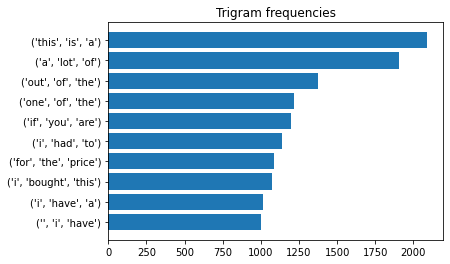

In [47]:
plt.barh(trig_words, trig_freqs)
plt.title('Trigram frequencies')
plt.show()

#### Nubes de palabras:

In [48]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

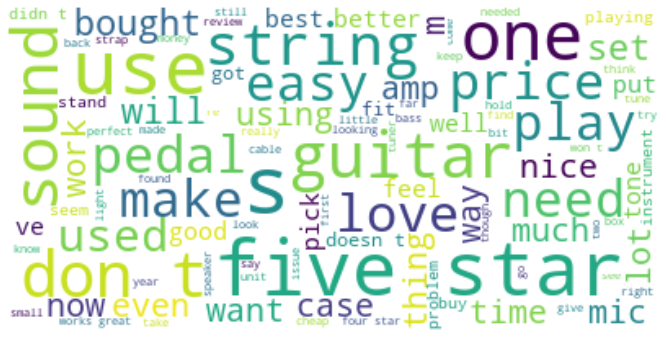

In [49]:
plot_word_cloud(words)
#Aún sin haber hecho un preprocesado muy a conciencia el resultado me parece muy representativo del tema de la compra de instrumentos musicales (en concreto guitarra y complementos) 

##### Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)

In [50]:
def print_sim_words(word, model1, model2):
    query = "Most similar to {}".format(word) 
    print(query)
    print("-"*len(query))
    for (sim1, sim2) in zip(model1.wv.most_similar(word), model2.wv.most_similar(word)):
        print("{}:{}{:.3f}{}{}:{}{:.3f}".format(sim1[0],
                                               " "*(20-len(sim1[0])), 
                                               sim1[1], 
                                               " "*10, 
                                               sim2[0],
                                               " "*(20-len(sim2[0])),
                                               sim2[1]))
    print("\n")

In [73]:
#voy probando con cantidades pequeñas y al final me animo a 10000 para intentar obtener mejores resultados al detectar la similitud
text=texts[:10000]

In [92]:
# voy modificando valores y aunque en algunas pruebas no pongo los mismos para los dos modelos, finalmente decido compararlos en igualdad de condiciones. 
w2v_mod_sg = Word2Vec(min_count=5,
                     sg=1,
                     window=3,
                     vector_size=200,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers= 4)

In [93]:
w2v_mod_cbow = Word2Vec(min_count=5,
                     sg=0,
                     window=3,
                     vector_size=200,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers= 4)

In [94]:
w2v_mod_sg.build_vocab(text)

In [95]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_mod_sg.wv)))

Vocabulario compuesto por 6505 palabras


In [96]:
w2v_mod_cbow.build_vocab(text)

In [97]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_mod_cbow.wv)))

Vocabulario compuesto por 6505 palabras


In [98]:
 w2v_mod_sg.train(text, total_examples=len(text), epochs=40)

(7785382, 21942680)

In [99]:
w2v_mod_cbow.train(text, total_examples=len(text), epochs=40) 
#hago varias pruebas con diferentes épocas 

(7786990, 21942680)

In [100]:
w2v_mod_sg.save('w2v_mod_sg.pkl')

In [101]:
w2v_mod_cbow.save('w2v_mod_cbow.pkl')

In [102]:
print_sim_words('guitar', w2v_mod_sg, w2v_mod_cbow)

Most similar to guitar
----------------------
the:                 0.621          guitar.:             0.603
on:                  0.600          guitar,:             0.556
and:                 0.600          guitars:             0.524
my:                  0.584          electric:            0.499
this:                0.581          ovation:             0.465
it:                  0.567          guitars.:            0.462
for:                 0.564          12-string:           0.454
your:                0.554          resonator:           0.450
a:                   0.553          banjo:               0.436
i:                   0.552          instrument:          0.435




In [103]:
print_sim_words('sound', w2v_mod_sg, w2v_mod_cbow)

Most similar to sound
---------------------
and:                 0.613          sound.:              0.575
sounds:              0.579          clear.:              0.545
is:                  0.574          crystal:             0.540
a:                   0.544          clarity:             0.530
it:                  0.544          sony's:              0.516
the:                 0.542          presence:            0.510
really:              0.541          vibrant:             0.509
but:                 0.531          definition:          0.502
are:                 0.520          sounded:             0.501
vibrant:             0.517          brighter,:           0.501




In [104]:
print_sim_words('price', w2v_mod_sg, w2v_mod_cbow)

Most similar to price
---------------------
to..:                0.615          price,:              0.649
expected!!:          0.609          price.:              0.634
quality:             0.575          prices:              0.608
price.:              0.540          cost.:               0.517
at:                  0.536          alternatives:        0.517
prompt:              0.529          prices.:             0.508
delivery!:           0.527          point.:              0.508
good:                0.519          quality:             0.494
this:                0.512          sale:                0.493
prices:              0.502          sure!:               0.489




#### Conclusiones del w2vec y notebook 1 en general:

Con las pruebas que he podido hacer con el word2vec me da la sensación de que el modelo skipgram funciona peor que el bag of words cuando no hay un buen preprocesado previo. Aunque los valores del cosine similarity son medios en casi todos los casos, las palabras similares detectadas son mucho más acertadas. 
Me gustaría volver sobre ello y con datos más limpios. 

Como resumen he podido comprobar que la mayoría de las reviews de instrumentos musicales son positivas (queda muy chulo en el wordcloud las palabras five star más grandes), aunque luego para seguir trabajando he balanceado. 

Al no haber quitado stopwords porque es parte del preprocesado y está en el siguiente notebook, los datos de los bigramas y trigramas no me dicen gran cosa. Resalto el trigrama "for the price", y los verbos que más aparecen son to be y have...punto para analizar. 

Sin haber limpiado demasiado me parece que ha salido un wordcloud que bien podría reflejar la realidad de la compra de instrumentos. veré cuando limpie más a fondo. 

En el siguiente punto cuando lematice y quite stopwords, seguro que mejoran estos resultados. quizá vuelva y lo ponga aquí... 